## Merge databases

In [1]:
import json
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# file path
weather_path = '../data/raw/meteotrentino-weather-station-data.json'
twitter_path = '../data/raw/social-pulse-trentino.geojson'

In [3]:
# load the data
with open(weather_path) as json_file:
    data_weather = json.load(json_file)

with open(twitter_path) as json_file:
    data_twitter = json.load(json_file)

# load the grid
grid_path = '../data/raw/trentino-grid.geojson'
df_grid = gpd.read_file(grid_path)

In [4]:
# extract features
twitter_features = gpd.GeoDataFrame(data_twitter['features'])
weather_features = gpd.GeoDataFrame(data_weather['features'])

In [5]:
start_timestamp = 1383260400
list(weather_features['timestamp'] - start_timestamp)
weather_features

,station,geomPoint.geom,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,minWind,maxWind,...,winds.2130,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345
0,T0071,"{'type': 'Point', 'coordinates': [10.79582897,...",905,2013-11-01,1383260400,4.5,12.3,False,0.0,2.5,...,0@183,,0@157,,0.4@228,0.3@248,,0@201,0@199,
1,T0032,"{'type': 'Point', 'coordinates': [11.25371981,...",1155,2013-11-01,1383260400,6.5,10.2,False,NaN,NaN,...,,,,,,,,,,
2,T0096,"{'type': 'Point', 'coordinates': [11.6645808, ...",1205,2013-11-01,1383260400,6.5,11.8,False,NaN,NaN,...,,,,,,,,,,
3,T0074,"{'type': 'Point', 'coordinates': [10.91841055,...",720,2013-11-01,1383260400,6.2,13.6,False,0.0,4.8,...,0.3@198,0.3@196,0.4@236,,0.9@15,0.6@345,1@244,0.5@192,0@157,
4,T0101,"{'type': 'Point', 'coordinates': [11.07973339,...",201,2013-11-01,1383260400,11.1,16.3,False,NaN,NaN,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,T0431,"{'type': 'Point', 'coordinates': [11.33626355,...",1055,2013-12-31,1388444400,-5.5,0.5,False,NaN,NaN,...,,,,,,,,,,
2191,T0428,"{'type': 'Point', 'coordinates': [10.64240944,...",525,2013-12-31,1388444400,-2.2,6.9,False,NaN,NaN,...,,,,,,,,,,
2192,T0437,"{'type': 'Point', 'coordinates': [11.76685208,...",1465,2013-12-31,1388444400,-9.9,-2.4,False,0.1,2.5,...,0.6@114,1@113,1.3@105,1.1@115,0.9@113,1@115,1.4@110,1.4@98,1.5@109,1.5@106
2193,T0469,"{'type': 'Point', 'coordinates': [11.6299111, ...",801,2013-12-31,1388444400,-4.1,2.7,False,0.1,1.4,...,0.7@38,0.7@83,0.3@148,,0.8@35,0.5@349,0.7@340,0.4@353,0.8@353,0.7@15


In [6]:
#pd.merge(twitter_features, weather_features, how='inner', on='timestamp')

In [7]:
#len(set(twitter_features['user']))

In [8]:
# remove unnecessary columns
twitter_features = twitter_features.drop('entities', axis=1)
twitter_features = twitter_features.drop('municipality.acheneID', axis=1)
print(twitter_features.columns)

# split date and time 
twitter_features['date'] = twitter_features['created'].str.split('T').str[0]
twitter_features['time'] = twitter_features['created'].str.split('T').str[1]
twitter_features = twitter_features.drop('created', axis=1)
twitter_features = twitter_features[['date', 'time', 'timestamp', 'user', 'geomPoint.geom', 'municipality.name', 'language']]

# keep only minutes
twitter_features['time'] = twitter_features['time'].str.rsplit(':', n=1).str[0]
#print(twitter_features)

Index(['created', 'timestamp', 'user', 'geomPoint.geom', 'municipality.name',
       'language'],
      dtype='object')


In [9]:
# make blocks of 15 minutes (column: hour_blocks)
minutes = twitter_features['time'].str.rsplit(':', n=1).str[1].astype(int)
minutes = (minutes // 15) * 15
minutes = minutes.astype(str)
minutes = minutes.str.zfill(2)
#print(minutes)

hours = twitter_features['time'].str.rsplit(':', n=1).str[0]

twitter_features['hour_blocks'] = hours + minutes
twitter_features

,date,time,timestamp,user,geomPoint.geom,municipality.name,language,hour_blocks
0,2013-11-01,00:04,1383260656,5fd4f31f75,"{'type': 'Point', 'coordinates': [11.13, 46.07]}",Trento,it,0000
1,2013-11-01,00:01,1383260474,68c0e98182,"{'type': 'Point', 'coordinates': [10.83, 46.23]}",Pinzolo,tl,0000
2,2013-11-01,00:43,1383262983,abe21fc052,"{'type': 'Point', 'coordinates': [11.46, 46.29]}",Cavalese,en,0030
3,2013-11-01,00:38,1383262717,94d1efbbfd,"{'type': 'Point', 'coordinates': [11.04, 45.89]}",Rovereto,it,0030
4,2013-11-01,00:45,1383263140,d261d03075,"{'type': 'Point', 'coordinates': [11.12, 46.2]}",San Michele all'Adige,ru,0045
...,...,...,...,...,...,...,...,...
27936,2013-12-31,00:25,1388445948,826558e00e,"{'type': 'Point', 'coordinates': [11.68, 46.42]}",Vigo di Fassa,it,0015
27937,2013-12-29,13:12,1388319166,06e9b1cdff,"{'type': 'Point', 'coordinates': [11.6, 46.31]}",Predazzo,it,1300
27938,2013-11-19,00:51,1384818699,e61ce711d3,"{'type': 'Point', 'coordinates': [11.3, 46.11]}",Sant'Orsola Terme,it,0045
27939,2013-11-23,09:49,1385196576,e61ce711d3,"{'type': 'Point', 'coordinates': [11.3, 46.11]}",Sant'Orsola Terme,it,0945


In [10]:
twitter_features['geometry'] = twitter_features['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
twitter_features.drop(columns=['geomPoint.geom'],inplace=True)

In [11]:
twitter_features['geometry'][2].x

11.46

In [17]:
df_stations = weather_features[['station', 'geomPoint.geom']]

In [96]:
df_stations.drop_duplicates()

,station,geometry,x,y
0,T0071,POINT (10.79583 46.31340),10.795829,46.313405
1,T0032,POINT (11.25372 45.94027),11.253720,45.940272
2,T0096,POINT (11.66458 46.38364),11.664581,46.383636
3,T0074,POINT (10.91841 46.35160),10.918411,46.351598
4,T0101,POINT (11.07973 46.15635),11.079733,46.156353
5,T0118,POINT (11.21802 46.17063),11.218019,46.170628
6,T0129,POINT (11.13565 46.07185),11.135653,46.071851
7,T0236,POINT (11.11886 46.39071),11.118862,46.390709
8,T0135,POINT (11.10131 46.09565),11.101305,46.095646
9,T0139,POINT (11.30223 46.10709),11.302230,46.107093


In [26]:
df_stations['geometry'] = df_stations['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
df_stations.drop(columns=['geomPoint.geom'],inplace=True)

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_10527/1081294236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations['geometry'] = df_stations['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_10527/1081294236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop(columns=['geomPoint.geom'],inplace=True)


In [29]:
df_stations['x'] = df_stations['geometry'].apply(lambda p: p.x)

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_10527/1462508067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations['x'] = df_stations['geometry'].apply(lambda p: p.x)


In [30]:
df_stations['y'] = df_stations['geometry'].apply(lambda p: p.y)

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_10527/3033094476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations['y'] = df_stations['geometry'].apply(lambda p: p.y)


In [31]:
df_stations

,station,geometry,x,y
0,T0071,POINT (10.79582897 46.31340453),10.795829,46.313405
1,T0032,POINT (11.25371981 45.94027203),11.253720,45.940272
2,T0096,POINT (11.6645808 46.38363633),11.664581,46.383636
3,T0074,POINT (10.91841055 46.35159801),10.918411,46.351598
4,T0101,POINT (11.07973339 46.15635256),11.079733,46.156353
...,...,...,...,...
2190,T0431,POINT (11.33626355 46.26304408),11.336264,46.263044
2191,T0428,POINT (10.64240944 45.94061606),10.642409,45.940616
2192,T0437,POINT (11.76685208 46.47831772),11.766852,46.478318
2193,T0469,POINT (11.6299111 46.05717778),11.629911,46.057178


In [32]:
twitter_features['x'] = twitter_features['geometry'].apply(lambda p: p.x)

In [33]:
twitter_features['y'] = twitter_features['geometry'].apply(lambda p: p.y)

In [34]:
twitter_features

,date,time,timestamp,user,municipality.name,language,hour_blocks,geometry,x,y
0,2013-11-01,00:04,1383260656,5fd4f31f75,Trento,it,0000,POINT (11.13 46.07),11.13,46.07
1,2013-11-01,00:01,1383260474,68c0e98182,Pinzolo,tl,0000,POINT (10.83 46.23),10.83,46.23
2,2013-11-01,00:43,1383262983,abe21fc052,Cavalese,en,0030,POINT (11.46 46.29),11.46,46.29
3,2013-11-01,00:38,1383262717,94d1efbbfd,Rovereto,it,0030,POINT (11.04 45.89),11.04,45.89
4,2013-11-01,00:45,1383263140,d261d03075,San Michele all'Adige,ru,0045,POINT (11.12 46.2),11.12,46.20
...,...,...,...,...,...,...,...,...,...,...
27936,2013-12-31,00:25,1388445948,826558e00e,Vigo di Fassa,it,0015,POINT (11.68 46.42),11.68,46.42
27937,2013-12-29,13:12,1388319166,06e9b1cdff,Predazzo,it,1300,POINT (11.6 46.31),11.60,46.31
27938,2013-11-19,00:51,1384818699,e61ce711d3,Sant'Orsola Terme,it,0045,POINT (11.3 46.11),11.30,46.11
27939,2013-11-23,09:49,1385196576,e61ce711d3,Sant'Orsola Terme,it,0945,POINT (11.3 46.11),11.30,46.11


In [39]:
import numpy as np

def haversine_distance_np(lat1, lon1, lat2, lon2):    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula    
    dlat = lat2 - lat1[:, np.newaxis]
    dlon = lon2 - lon1[:, np.newaxis]    
    a = np.sin(dlat / 2)**2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth's radius in kilometers (6371 km)    
    radius = 6371
    return radius * c

In [40]:
# Extract latitude and longitude arrays
twitter_lat = twitter_features['y'].values
twitter_lon = twitter_features['x'].values
station_lat = df_stations['y'].values
station_lon = df_stations['x'].values

In [41]:
# Compute distances using NumPy (vectorized calculation)
distances = haversine_distance_np(twitter_lat, twitter_lon, station_lat, station_lon)

In [100]:
# Find the index of the nearest station for each Twitter point
nearest_station_index = np.argmin(distances, axis=1)

# Assign the nearest station index to twitter_features
twitter_features['nearest_station_index'] = df_stations['station'].iloc[nearest_station_index]

IndexError: positional indexers are out-of-bounds

In [101]:
list(nearest_station_index)

[6,
 0,
 19,
 11,
 29,
 6,
 11,
 6,
 6,
 0,
 36,
 7,
 6,
 6,
 20,
 6,
 29,
 29,
 29,
 11,
 19,
 6,
 19,
 6,
 24,
 7,
 10,
 9,
 7,
 6,
 3,
 5,
 29,
 6,
 25,
 5,
 25,
 6,
 6,
 6,
 25,
 6,
 25,
 5,
 7,
 6,
 6,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 5,
 9,
 5,
 19,
 7,
 19,
 2,
 9,
 2,
 25,
 25,
 25,
 25,
 25,
 2,
 5,
 6,
 5,
 2,
 5,
 25,
 25,
 0,
 29,
 29,
 1,
 0,
 25,
 25,
 19,
 19,
 0,
 2,
 30,
 19,
 6,
 25,
 19,
 2,
 9,
 19,
 19,
 19,
 2,
 19,
 19,
 19,
 24,
 11,
 24,
 24,
 24,
 36,
 6,
 2,
 11,
 25,
 0,
 10,
 25,
 6,
 5,
 6,
 11,
 19,
 25,
 6,
 11,
 29,
 2,
 6,
 11,
 0,
 7,
 9,
 6,
 9,
 25,
 9,
 9,
 11,
 9,
 9,
 7,
 2,
 9,
 2,
 6,
 0,
 21,
 9,
 19,
 19,
 2,
 11,
 9,
 9,
 9,
 9,
 2,
 2,
 25,
 25,
 6,
 24,
 24,
 6,
 9,
 24,
 6,
 6,
 7,
 11,
 24,
 19,
 9,
 9,
 25,
 25,
 25,
 6,
 25,
 30,
 37,
 31,
 30,
 25,
 11,
 6,
 25,
 25,
 11,
 25,
 24,
 37,
 8,
 37,
 21,
 6,
 36,
 9,
 6,
 36,
 25,
 9,
 25,
 6,
 25,
 11,
 6,
 24,
 25,
 6,
 6,
 25,
 25,
 6,
 2,
 25,
 25

In [99]:
df_stations = df_stations.drop_duplicates()
df_stations

,station,geometry,x,y
0,T0071,POINT (10.79583 46.31340),10.795829,46.313405
1,T0032,POINT (11.25372 45.94027),11.253720,45.940272
2,T0096,POINT (11.66458 46.38364),11.664581,46.383636
3,T0074,POINT (10.91841 46.35160),10.918411,46.351598
4,T0101,POINT (11.07973 46.15635),11.079733,46.156353
5,T0118,POINT (11.21802 46.17063),11.218019,46.170628
6,T0129,POINT (11.13565 46.07185),11.135653,46.071851
7,T0236,POINT (11.11886 46.39071),11.118862,46.390709
8,T0135,POINT (11.10131 46.09565),11.101305,46.095646
9,T0139,POINT (11.30223 46.10709),11.302230,46.107093


In [93]:
twitter_features

,date,time,timestamp,user,municipality.name,language,hour_blocks,geometry,nearest_station_index
0,2013-11-01,00:04,1383260656,5fd4f31f75,Trento,it,0000,POINT (11.13000 46.07000),6
1,2013-11-01,00:01,1383260474,68c0e98182,Pinzolo,tl,0000,POINT (10.83000 46.23000),0
2,2013-11-01,00:43,1383262983,abe21fc052,Cavalese,en,0030,POINT (11.46000 46.29000),19
3,2013-11-01,00:38,1383262717,94d1efbbfd,Rovereto,it,0030,POINT (11.04000 45.89000),11
4,2013-11-01,00:45,1383263140,d261d03075,San Michele all'Adige,ru,0045,POINT (11.12000 46.20000),29
...,...,...,...,...,...,...,...,...,...
27936,2013-12-31,00:25,1388445948,826558e00e,Vigo di Fassa,it,0015,POINT (11.68000 46.42000),2
27937,2013-12-29,13:12,1388319166,06e9b1cdff,Predazzo,it,1300,POINT (11.60000 46.31000),21
27938,2013-11-19,00:51,1384818699,e61ce711d3,Sant'Orsola Terme,it,0045,POINT (11.30000 46.11000),9
27939,2013-11-23,09:49,1385196576,e61ce711d3,Sant'Orsola Terme,it,0945,POINT (11.30000 46.11000),9


In [60]:
twitter_features = twitter_features.drop('x', axis=1)

In [61]:
twitter_features = twitter_features.drop('y', axis=1)

In [62]:
twitter_features

,date,time,timestamp,user,municipality.name,language,hour_blocks,geometry,nearest_station_index
0,2013-11-01,00:04,1383260656,5fd4f31f75,Trento,it,0000,POINT (11.13 46.07),6
1,2013-11-01,00:01,1383260474,68c0e98182,Pinzolo,tl,0000,POINT (10.83 46.23),0
2,2013-11-01,00:43,1383262983,abe21fc052,Cavalese,en,0030,POINT (11.46 46.29),19
3,2013-11-01,00:38,1383262717,94d1efbbfd,Rovereto,it,0030,POINT (11.04 45.89),11
4,2013-11-01,00:45,1383263140,d261d03075,San Michele all'Adige,ru,0045,POINT (11.12 46.2),29
...,...,...,...,...,...,...,...,...,...
27936,2013-12-31,00:25,1388445948,826558e00e,Vigo di Fassa,it,0015,POINT (11.68 46.42),2
27937,2013-12-29,13:12,1388319166,06e9b1cdff,Predazzo,it,1300,POINT (11.6 46.31),21
27938,2013-11-19,00:51,1384818699,e61ce711d3,Sant'Orsola Terme,it,0045,POINT (11.3 46.11),9
27939,2013-11-23,09:49,1385196576,e61ce711d3,Sant'Orsola Terme,it,0945,POINT (11.3 46.11),9


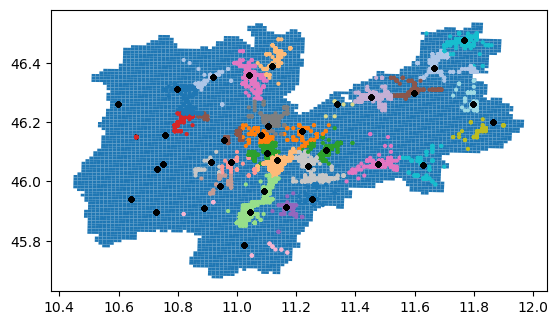

In [90]:
ax = df_grid.plot()

twitter_features = gpd.GeoDataFrame(twitter_features)
twitter_features.plot(column='nearest_station_index', ax=ax, cmap='tab20', markersize=4)

df_stations = gpd.GeoDataFrame(df_stations)
df_stations.plot(ax=ax, color='black', markersize=8)

plt.savefig('fig.png', dpi=500)